# Mout Google Drive

In [1]:

# https://towardsdatascience.com/google-drive-google-colab-github-dont-just-read-do-it-5554d5824228
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)
# %pwd 
# %ls


Mounted at /content/drive


# run github settings


In [2]:
%run /content/drive/MyDrive/CNNStanford/pytorch/pytorch_sandbox/Colab_Helper.ipynb

mkdir: cannot create directory ‘/content/drive/My Drive/CNNStanford/pytorch’: File exists
PROJECT_PATH: /content/drive/My Drive/CNNStanford/pytorch
/content/drive/My Drive/CNNStanford/pytorch/pytorch_sandbox


In [3]:
MESSAGE = "ex1.2 cleaner"
!git add .

In [ ]:
!git commit -m "{MESSAGE}"
!git push "{GIT_PATH}"

In [ ]:
import sys
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import time
RGB2SEPIA = [[0.393, 0.769, 0.189],
             [0.349, 0.686, 0.168],
             [0.272, 0.534, 0.131]]

A helper function that gets a 3D tensor (image) and displays it using matplotlib

In [ ]:
# %% A helper function that gets a 3D tensor (image) and displays it using matplotlib
# You can assume that the tensor is size 3xHxW
def tensor_show(image_tensor, title=None):
    plt.imshow(image_tensor.permute(1, 2, 0))
    if title: plt.title(title)
    plt.show()

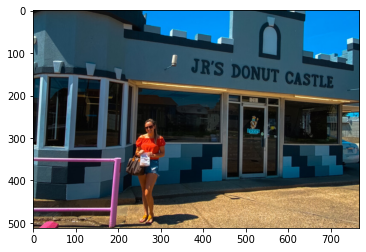

In [ ]:
image_path = f"{PROJECT_PATH}/pytorch_sandbox/images/rgb_768_512.png"
img_input = Image.open(image_path)  # (768, 512, 3)
plt.imshow(img_input)
plt.show()

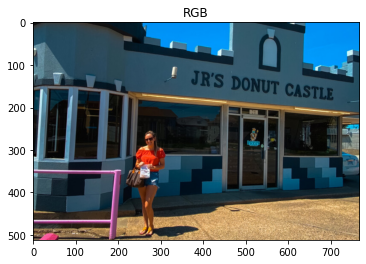

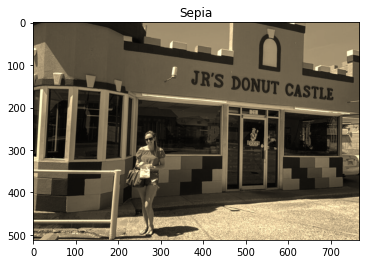

time to 10 convolutions on CPU=37.92278265953064 sec


In [ ]:
# %% Note - the 'main' wrapper is required to run remote-debugging on GPU
def main(argv):

    #%% 1.1 load image
    # hint: to open the image, use PIL.Image.open
    image_path = f"{PROJECT_PATH}/pytorch_sandbox/images/rgb_768_512.png"
    img_input = Image.open(image_path)  # (768, 512, 3)
    # plt.imshow(img_input)
    # plt.show()

    # %% 1.2 image to tensor
    # hint: to transform image data to tensor, use torchvision.transforms.ToTensor()
    #   PIL or ndarray (H x W x C) range [0, 255] to Tensor (C x H x W) range [0.0, 1.0]
    img_tensor = transforms.ToTensor()(img_input) # (3, 768, 512)
    # img_tensor.size()
    # tensor_show(img_tensor)

    # %% 2. Convert the colors to Sepia tone, matmul, view
    img_sepia = torch.tensor(RGB2SEPIA) @ img_tensor.view(3, -1)
    img_sepia.clip(0, 1)  # to impose range of sepia
    img_sepia = img_sepia.view_as(img_tensor) # restore shape of RGB image

    # %% 3. Display the original and sepia RGB tensors, using plt.imshow & permute
    tensor_show(img_tensor, "RGB")
    tensor_show(img_sepia, "Sepia")

    # %% 4. Create a batch of 100x3xHxW by duplicating the same image
    # repeat(copies) / expand (not copy)
    batch = img_sepia.expand(100, -1, -1, -1)  # -1 keeps the same dimension

    # %% 5. Apply Conv2D on the batch (3 filters, kernel size 7x7, padding=3)
    W = torch.randn(3, 3, 7, 7)  # first 3 for out channels, 3 filters, 7x7 kernel size

    # #### Measuring time ##### A: time=2.672631025314331
    # start = time.time()
    # y_conv = F.conv2d(batch, W, padding=3)
    # end = time.time()
    # print(f"time={end - start}")

    # %% 6. Apply the same Conv2D 10 times consecutively, and measure the time it takes
    #### Measuring time ##### A: time=23.848090410232544
    start = time.time()
    for _ in range(10):
        batch = F.conv2d(batch, W, padding=3)
    end = time.time()
    print(f"time to 10 convolutions on CPU={end - start} sec")

    # %% Repeat (6), but this time run on GPU.  Measure runtime and compare to 6
    #### Running a convolution on GPU ##### A: GPU=0.03794717788696289
    # X is the input tensor (batch)
    # W is the weights tensor
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        batch = batch.to(device)
        W = W.to(device)
        start = time.time()
        for _ in range(10):
            # y_conv = F.conv2d(batch, W, padding=3) -> this was the same conv 10 times, instead of one on top of the other...
            batch = F.conv2d(batch, W, padding=3)
        end = time.time()
        print(f"time on GPU={end - start}")

#%%
if __name__ == "__main__":
    main(sys.argv)